# NN e RNN

Nesse notebook, vamos treinar os modelos baseados em redes neurais.

In [1]:
import pickle
import json
from typing import Dict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


## Preparação dos dados

Precisamos primeiramente preparar os dados.

Vamos carregar os conjuntos de validação e treino, separar as features e o target, e normalizá-los.

### Carregar

Carregamos os conjuntos separados anteriormente, junto com a descrição.

In [2]:
dataset_folder = "..\\data"

In [3]:
file = open(dataset_folder+"\\train_df", 'rb')
train_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\val_df", 'rb')
val_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\info.json", 'r')
info_dict = json.load(file)
file.close()

In [5]:
features_names = info_dict["feature_names"]

features_names

['Nome_municipio',
 'Dia',
 'Precipitacao',
 'Pressao_at_max',
 'Pressao_at_min',
 'Radiacao',
 'Temp_max',
 'Temp_min',
 'Umidade',
 'Max_vent',
 'Velocidade_vent',
 'Pop_estimada']

### Verificação

Verifica se existe algum problema com os dados.

In [6]:
train_df.isna().sum()

Nome_municipio     0
Dia                0
Precipitacao       0
Pressao_at_max     0
Pressao_at_min     0
Radiacao           0
Temp_max           0
Temp_min           0
Umidade            0
Max_vent           0
Velocidade_vent    0
Pop_estimada       0
Casos              0
Casos_pela_pop     0
dtype: int64

In [7]:
val_df.isna().sum()

Nome_municipio     0
Dia                0
Precipitacao       0
Pressao_at_max     0
Pressao_at_min     0
Radiacao           0
Temp_max           0
Temp_min           0
Umidade            0
Max_vent           0
Velocidade_vent    0
Pop_estimada       0
Casos              0
Casos_pela_pop     0
dtype: int64

### Separação

Separamos os conjuntos de treino e validação.

In [8]:
train_features = train_df[features_names]
val_features = val_df[features_names]

drop_columns = ["Nome_municipio", "Dia"]

for column in drop_columns:
    train_features.drop(column, axis="columns", inplace=True)
    val_features.drop(column, axis="columns", inplace=True)

train_target = train_df["Casos_pela_pop"]
val_target = val_df["Casos_pela_pop"]

C:\Python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
n_features = train_features.shape[1]
n_target = 1

### Normalização

Normalizamos os dados, e salvamos as distribuições para podermos normalizar posteriormente os outros conjuntos.

Calculamos e salvamos as distribições das features

In [10]:
description = train_features.describe()

In [11]:
train_dist = {}

for column in train_features.columns:
    train_dist[column] = {}
    train_dist[column]["mean"] = description[column]["mean"]
    train_dist[column]["std"] = description[column]["std"]

In [12]:
file = open("train_dist.json", "w")
json.dump(train_dist, file)
file.close()

Normalizamos as features

In [13]:
for df in [train_features, val_features]:
    for column in train_features:
        df.loc[:, column] = (df[column]-train_dist[column]["mean"])/train_dist[column]["std"]

C:\Python38\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Verificamos se estão corretamente normalizadas

In [14]:
train_features.describe()

,Precipitacao,Pressao_at_max,Pressao_at_min,Radiacao,Temp_max,Temp_min,Umidade,Max_vent,Velocidade_vent,Pop_estimada
count,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06
mean,-2.245522e-16,-1.432445e-15,2.329507e-14,-1.473959e-15,-1.436714e-15,1.905683e-15,5.725955e-16,-1.154622e-16,-9.053457e-16,-1.784184e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.060475e-01,-3.754402e+00,-3.763698e+00,-2.740855e+00,-5.989725e+00,-6.060539e+00,-3.623111e+00,-2.937551e+00,-1.826297e+00,-3.112124e-01
25%,-3.060475e-01,-7.682675e-01,-7.684687e-01,-6.173573e-01,-5.796011e-01,-5.648660e-01,-6.524339e-01,-6.598478e-01,-6.869443e-01,-2.882414e-01
50%,-3.060475e-01,2.465197e-02,2.413291e-02,1.036241e-01,1.490688e-01,1.825455e-01,6.375657e-02,-7.367400e-02,-1.347116e-01,-2.394346e-01
75%,-2.515670e-01,9.055588e-01,9.042712e-01,7.030119e-01,6.980666e-01,7.321128e-01,7.206848e-01,5.459954e-01,5.740864e-01,-1.117164e-01
max,2.892274e+01,2.317003e+00,2.323264e+00,7.149043e+00,3.233438e+00,4.557101e+00,2.277895e+00,2.342352e+01,1.335032e+01,1.216895e+01


Realizamos o mesmo processo com o target

In [15]:
target_dist = {}
target_dist["mean"] = train_target.mean()
target_dist["std"] = train_target.std()

In [16]:
file = open("target_dist.json", "w")
json.dump(target_dist, file)
file.close()

OBS: Só descobrimos posteriormente que a normalização do target não é realizada corretamente nessa célula. Portanto, em todos os momentos, o target utilizado é o target não normalizado.

In [17]:
for df in [train_target, val_target]:
    df = (df-target_dist["mean"])/target_dist["std"]

## Infraestrutura para treino

Aqui, preparamos a estrutura básica para gerenciar os modelos que serão treinados.

Para o logging das métricas e pesos, decidimos utilizar a ferramenta "Weights and Biases". Os loggings obtidos estão públicos nos nossos projetos:

Parte do projeto | Link
-|-
Modelos treinados com dados diários | https://wandb.ai/breath/BReATH-%20Day/overview
Modelos treinados com dados semanais | https://wandb.ai/breath/BReATH/overview?workspace=user-eltoncn
AGs utilizados para otimizar os modelos semanais | https://wandb.ai/breath/BReATH_AG/overview?workspace=user-eltoncn
Ensemble treinados para utilizar os outros modelos (Disponível em outro notebook) | https://wandb.ai/breath/BReATH_Ensemble/overview?workspace=user-eltoncn

In [18]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eltoncn (use `wandb login --relogin` to force relogin)


True

Tamanho do batch

In [19]:
BATCH_SIZE = 84959
STEPS_PER_EPOCH = int(len(train_features)/BATCH_SIZE)
STEPS_PER_EPOCH

21

In [20]:
from typing import Dict

class ModelManager:
    '''
        Gerencia os modelos criados
    '''

    def __init__(self, project_name, train_features, train_target, val_features, val_target, save_dir="."):
        '''
            Construtor do ModelManager.

            Parâmetros:
                project_name: Nome do projeto. Utilizado para logar no wandb.
                train_features: Features do conjunto de treino.
                train_target: Coluna objetivo do conjunto de treino.
                val_features: Features do conjunto de validação.
                val_target: Coluna objetivo do conjunto de validação.
                save_dir: Diretório para salvar os modelos.
        
        '''
        self._project_name = project_name

        self._save_dir = save_dir
        self._model_save_dir = self._save_dir+"\\models"
        self._log_dir = self._save_dir+"\\log"
        
        self._models : Dict[str, keras.Model] = {}
        self._current_model = ""

        self._architectures = {}
        self._hist = {}

        self._data = {}
        self._data["train_features"] = np.asarray(train_features)
        self._data["train_target"] = np.asarray(train_target)
        self._data["val_features"] = np.asarray(val_features)
        self._data["val_target"] = np.asarray(val_target)

        self._sample_features = self._data["train_features"][:10000]
        self._sample_target = self._data["train_target"][:10000]
        self._sample_x = train_df["Dia"][:10000]

    def set_sample(self, sample_features, sample_target, sample_x):
        '''
            Define os dados para plotar o gráfico exemplo.

            Parâmetros:
                sample_features: Features para plotar o gráfico.
                sapmle_target: Ground truth
                sample_x: Dados para utilizar no eixo x do gráfico.
        '''
        self._sample_features = sample_features
        self._sample_target = sample_target
        self._sample_x = sample_x

    def register_model(self, model, model_name, architecture_name):
        '''
            Registra um modelo para ser treinado.

            Parâmetros:
                model: Modelo a ser treinado.
                model_name: Nome do modelo.
                architecture_name: Nome da arquitetura que o modelo utiliza.
        '''

        self._current_model = model_name

        self._models[model_name] = model
        self._architectures[model_name] = architecture_name

    def compile_fit_save(self, epochs, optimizer, model_name=None, batch_size=BATCH_SIZE, patience=None, verbose='auto', loss="mean_squared_error", group=None):
        '''
            Compila, treina e salva o modelo.

            Parâmetros:
                epochs: Quantidade de epochs que o modelo será treinado.
                optimizer: Otimizador que será utilizado.
                model_name: Nome do modelo que será treinado. None treina o último modelo registrado.
                batch_size: Tamanho do batch.
                patience: Paciência do treino. None treina o modelo até a última epoch.
                verbose: Verbose do treino.
                loss: Função de perda utilizada para o treino.
                group: Nome do grupo do modelo (utilizado pelo wandb).
        '''
        
        if model_name is None:
            model_name = self._current_model
        else:
            self._current_model = model_name

        learning_rate = optimizer.learning_rate.numpy()
        
        config = {}
        config["leaning_rate"] = learning_rate
        config["epochs"] = epochs
        config["architecture"] = self._architectures[model_name]
        config["batch_size"] = batch_size
        config["optimizer"] = optimizer._name
        config["loss"] = loss
        config["patience"] = patience

        run = wandb.init(project=self._project_name, entity="breath",
                           config = config, group=group)
        
        run.name = model_name

        metrics = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error]

        model = self._models[model_name]
        model.compile(optimizer=optimizer, 
                        loss= tf.keras.losses.get(loss),
                        metrics=metrics)
        
        callbacks = []
        callbacks.append(WandbCallback("val_mean_squared_error" ))
        #callbacks.append(keras.callbacks.TensorBoard(log_dir=self._log_dir, histogram_freq=1))
        
        if patience is not None:
            callbacks.append(keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=patience))

        self._hist[model_name] = model.fit(x=self._data["train_features"], y=self._data["train_target"], 
                                    validation_data=(self._data["val_features"], self._data["val_target"]),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks= callbacks, verbose=verbose)

        
        self.plot_sample()
        wandb.log({"predictions":plt})
        plt.show()

        wandb.finish()

    def plot_sample(self, show=False):
        '''
            Plota o modelo atual com os dados de exemplo.

            Parâmetros:
                show: Se o gráfico deverá ser mostrado na tela.
        '''
        model  = self._models[self._current_model]

        predictions = model.predict(self._sample_features).flatten()
        plt.plot(self._sample_x, self._sample_target)
        plt.plot(self._sample_x, predictions)
        plt.ylabel("Casos/População")
        plt.legend(["GT", "Predito"])

        if show:
            plt.show()


    def save(self, model_name):
        '''
            Salva um modelo.

            Parâmetros:
                model_name: Nome do modelo que vai ser salvo.
        '''
        self._models[model_name].save(self._model_save_dir+"\\"+model_name)

        try:
            keras.models.load_model(self._model_save_dir)
        except Exception as e:
            print(e)
            print("ERRO AO SALVAR O MODELO")
    
    def load(self, model_name):
        '''
            Carrega um modelo.

            Parâmetros:
                model_name: Nome do modelo que vai ser carregado.
        '''
        self._models[model_name] = keras.models.load_model(self._model_save_dir)

        self._current_model = model_name

In [21]:
manager = ModelManager("BReATH", train_features.to_numpy(), train_target.to_numpy(), val_features.to_numpy(), val_target.to_numpy(), save_dir=".\\save")

Nos certificamos que estamos utilizado a GPU

In [22]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0],True)


Aqui, lançamos uma exceção, visto que tivemos que re-executar os passos acima muitas vezes

In [23]:
# Lança exceção (útil para executar todo o notebook até este ponto após falha do tf enquanto treinava algum modelo)

raise Exception()

Exception: 

## Modelos parte 1

Treinamos alguns modelos com os dados disponíveis. Percebemos posteriormente que utilizar dados diários não forneceu bons modelos, então nenhum modelo treinado aqui foi utilizado, porém as arquiteturas foram retreinadas com os dados semanais posteriormente. Veja a subseção de conclusões no fim dessa seção.

### NN

Algumas redes neurais treinadas.

In [1]:
# Primeiro modelo treinado
def create_first():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="relu")(input)
    x = keras.layers.Dense(100, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
first_model = create_first()

manager.register_model(first_model, "first", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

In [ ]:
# Tentamos aumentar o modelo

def create_larger():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu")(input)
    x = keras.layers.Dense(1000, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
larger_model = create_larger()
manager.register_model(larger_model, "larger", "larger")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

In [ ]:
# Diminuir o modelo para diminuir o overfitting

def create_small():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="relu")(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

small_model = create_small()
manager.register_model(small_model, "small", "small")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

### RNN

Testamos alguns modelos utilizando LSTMs.

É interessante observar que tivemos alguns problemas criando os modelos com LSTM, já que foram os únicos que chegaram a utilizar mais memória que disponível. Tivemos que aumentar a quantidade de batchs na célula anterior para conseguir treinar alguns modelos.

In [ ]:
# Uma camada com unidades LSTM
def create_first_lstm():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32)(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_first_lstm()
manager.register_model(model, "first_lstm", "first_lstm")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
# Descobrindo o uso de return_sequences (gera erro :)
def create_lstm2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32, return_sequences=True)(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm2()
manager.register_model(model, "lstm2", "lstm2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
# Duas camadas
def create_lstm3():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32, return_sequences=True)(input)
    x = keras.layers.LSTM(32)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:

model = create_lstm3()
manager.register_model(model, "lstm3", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
# CNN (gera erro tb :), não tínhamos ideia do pq o modelo parecia tão ruim
def create_cnn():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Conv1D(32, kernel_size=(3, ))(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_cnn()
manager.register_model(model, "cnn1", "cnn1")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

### Outros testes
Tentamos trocar o otimizador, função de ativação, a perda e os dados.

In [ ]:
# Utilizando o SGD
model = create_first()
manager.register_model(model, "first_sgd", "first")
manager.compile_fit_save(optimizer=keras.optimizers.SGD(learning_rate=0.0005), epochs=100)

In [ ]:
# Tentamos trocar a função de ativação para a sigmoide. Não melhorou os resultados.
def create_first_sigmoid():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="sigmoid")(input)
    x = keras.layers.Dense(100, activation="sigmoid")(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_first_sigmoid()
manager.register_model(model, "first_sigmoid", "first_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
# Tentamos aumentar ela, já que pareceu ser treinável por mais tempo.
def create_larger_sigmoid():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="sigmoid")(input)
    x = keras.layers.Dense(1000, activation="sigmoid")(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_larger_sigmoid()
manager.register_model(model, "larger_sigmoid", "larger_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

In [ ]:
# LSTM com a sigmoide.
def create_lstm_sigmoid():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32)(input)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm_sigmoid()
manager.register_model(model, "lstm_sigmoid", "lstm_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

In [ ]:
# 2 camadas de LSTM com a sigmoide.
def create_lstm_sigmoid2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32, return_sequences=True)(input)
    x = keras.layers.LSTM(32)(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm_sigmoid2()
manager.register_model(model, "lstm_sigmoid2", "lstm_sigmoid2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

In [ ]:
# O primeiro modelo, dessa vez utilizando a perda MSLE
model = create_first()
manager.register_model(model, "first_log", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20, loss="mean_squared_logarithmic_error")

Tentamos remover os dados nulos, já que os gráficos gerados pelos modelos eram sempre nulos.

In [ ]:
train_features_zeroless = train_features.to_numpy()
train_target_zeroless = train_target.to_numpy()
val_features_zeroless = val_features.to_numpy()
val_target_zeroless = val_target.to_numpy()

mask = train_target_zeroless != 0
val_mask = val_target_zeroless != 0

train_target_zeroless = train_target_zeroless[mask]
train_features_zeroless = train_features_zeroless[mask]
val_features_zeroless = val_features_zeroless[val_mask]
val_target_zeroless = val_target_zeroless[val_mask]

In [ ]:
train_features.describe()

,Precipitacao,Pressao_at_max,Pressao_at_min,Radiacao,Temp_max,Temp_min,Umidade,Max_vent,Velocidade_vent,Pop_estimada
count,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06
mean,-2.245522e-16,-1.432445e-15,2.329507e-14,-1.473959e-15,-1.436714e-15,1.905683e-15,5.725955e-16,-1.154622e-16,-9.053457e-16,-1.784184e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.060475e-01,-3.754402e+00,-3.763698e+00,-2.740855e+00,-5.989725e+00,-6.060539e+00,-3.623111e+00,-2.937551e+00,-1.826297e+00,-3.112124e-01
25%,-3.060475e-01,-7.682675e-01,-7.684687e-01,-6.173573e-01,-5.796011e-01,-5.648660e-01,-6.524339e-01,-6.598478e-01,-6.869443e-01,-2.882414e-01
50%,-3.060475e-01,2.465197e-02,2.413291e-02,1.036241e-01,1.490688e-01,1.825455e-01,6.375657e-02,-7.367400e-02,-1.347116e-01,-2.394346e-01
75%,-2.515670e-01,9.055588e-01,9.042712e-01,7.030119e-01,6.980666e-01,7.321128e-01,7.206848e-01,5.459954e-01,5.740864e-01,-1.117164e-01
max,2.892274e+01,2.317003e+00,2.323264e+00,7.149043e+00,3.233438e+00,4.557101e+00,2.277895e+00,2.342352e+01,1.335032e+01,1.216895e+01


In [ ]:
manager._data["train_features"] = train_features_zeroless
manager._data["train_target"] = train_target_zeroless
manager._data["val_features"] = val_features_zeroless
manager._data["val_target"] = val_target_zeroless

In [ ]:
train_features_zeroless.shape

(28849, 10)

In [ ]:
model = create_first()
manager.register_model(model, "first_zeroless", "first_zeroless")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

In [ ]:
first_model = create_first()

manager.register_model(first_model, "first", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

### Conclusões

Todos os modelos treinados até aqui, embora as métricas diminuam, não parecem gerar saídas úteis. Plotando a saída em um conjunto reduzido de dados, os modelos predizeram 0 ou apenas ruído. Concluímos que a alta quantidade de dias com nenhum caso acabou por atrapalhar o modelo. Tentamos então, nos próximos passos, agrupar os dados por semana, aumentando a densidade de casos.

## Semanas

Aqui, agrupamos os dados por semana para aumentar a densidade de casos em cada entrada.

Como já tínhamos trabalhado com agrupamento dos dados por dia utilizando SQL, achamos mais simples reconverter os conjuntos para BDs SQL, realizar o agrupamento e converter de volta para DataFrames do Pandas.

### Conversão

In [29]:
# Preparamos o banco de dados

from sqlalchemy import create_engine
engine = create_engine("sqlite://", echo=False)

In [30]:
engine.execute("DROP TABLE IF EXISTS Clima_Casos")

#Convertemos os dados para SQL
train_df.to_sql("Clima_Casos", con=engine)

# Realizamos a query para agrupar os dados
query = "SELECT Nome_municipio, Sum(Precipitacao) as Precipitacao, Avg(Pressao_at_max) as Pressao_at_max, "
query += "Avg(Pressao_at_min) as Pressao_at_min, Avg(Radiacao) as Radiacao, Avg(Temp_max) as Temp_max, Avg(Temp_min) as Temp_min, "
query += "Avg(Umidade) as Umidade, Avg(Max_vent) as Max_vent, Avg(Velocidade_vent) as Velocidade_vent, Pop_estimada, "
query += " DIA/7 AS Semana, Sum(Casos) as Casos FROM Clima_Casos GROUP BY Nome_municipio, Semana"

train_df_week = pd.read_sql_query(query, engine)

Vamos plotar o histograma de casos, comprovando a hipótese de que agrupar os dados por semana ajudaria a eliminar entradas nulas.

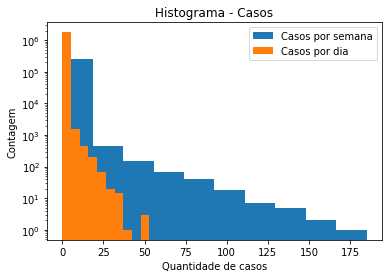

In [ ]:
plt.hist(train_df_week["Casos"])
plt.hist(train_df["Casos"])
plt.yscale("log")

plt.xlabel("Quantidade de casos")
plt.ylabel("Contagem")

plt.legend(["Casos por semana", "Casos por dia"])

plt.title("Histograma - Casos")

plt.show()

Realizamos o mesmo processo com o conjunto de validação

In [31]:
engine.execute("DROP TABLE IF EXISTS Clima_Casos")

val_df.to_sql("Clima_Casos", con=engine)
query = "SELECT Nome_municipio, Sum(Precipitacao) as Precipitacao, Avg(Pressao_at_max) as Pressao_at_max, "
query += "Avg(Pressao_at_min) as Pressao_at_min, Avg(Radiacao) as Radiacao, Avg(Temp_max) as Temp_max, Avg(Temp_min) as Temp_min, "
query += "Avg(Umidade) as Umidade, Avg(Max_vent) as Max_vent, Avg(Velocidade_vent) as Velocidade_vent, Pop_estimada, "
query += " DIA/7 AS Semana, Sum(Casos) as Casos FROM Clima_Casos GROUP BY Nome_municipio, Semana"

val_df_week = pd.read_sql_query(query, engine)

### Separação

Separamos novamente os conjuntos

In [32]:
features_names.remove("Dia")

train_features = train_df_week[features_names]
val_features = val_df_week[features_names]

drop_columns = ["Nome_municipio"]

for column in drop_columns:
    train_features.drop(column, axis="columns", inplace=True)
    val_features.drop(column, axis="columns", inplace=True)

train_target = train_df_week["Casos"]
val_target = val_df_week["Casos"]

C:\Python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
n_features = train_features.shape[1]
n_target = 1

### Normalização

E normalizamos eles, salvando as novas distribuições.

In [34]:
description = train_features.describe()

In [35]:
train_dist = {}

for column in train_features.columns:
    train_dist[column] = {}
    train_dist[column]["mean"] = description[column]["mean"]
    train_dist[column]["std"] = description[column]["std"]

In [ ]:
file = open("train_dist_week.json", "w")
json.dump(train_dist, file)
file.close()

In [36]:
for df in [train_features, val_features]:
    for column in train_features:
        df.loc[:, column] = (df[column]-train_dist[column]["mean"])/train_dist[column]["std"]

C:\Python38\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [ ]:
train_features.describe()

,Precipitacao,Pressao_at_max,Pressao_at_min,Radiacao,Temp_max,Temp_min,Umidade,Max_vent,Velocidade_vent,Pop_estimada
count,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05,2.611090e+05
mean,-7.750119e-17,-2.420824e-16,4.843389e-15,-1.110596e-15,1.462944e-16,2.586276e-16,5.024515e-16,2.473072e-16,-3.082631e-16,3.047799e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.299823e-01,-3.614769e+00,-3.610927e+00,-3.585174e+00,-5.137426e+00,-5.304860e+00,-4.092521e+00,-4.211235e+00,-2.141092e+00,-3.111794e-01
25%,-6.299823e-01,-7.667900e-01,-7.658991e-01,-6.134432e-01,-5.791706e-01,-6.178027e-01,-5.919074e-01,-6.064536e-01,-6.777965e-01,-2.880590e-01
50%,-4.576515e-01,2.255351e-02,2.214004e-02,2.849036e-02,1.310423e-01,1.588711e-01,1.473996e-01,1.788824e-03,-8.908246e-02,-2.389350e-01
75%,2.316720e-01,9.144444e-01,9.132943e-01,6.453361e-01,6.985784e-01,7.464417e-01,7.238939e-01,6.340860e-01,5.953007e-01,-1.114829e-01
max,1.408379e+01,2.314561e+00,2.321065e+00,7.770369e+00,3.304806e+00,4.004419e+00,2.653008e+00,7.335062e+00,1.178436e+01,1.225012e+01


In [37]:
target_dist = {}
target_dist["mean"] = train_target.mean()
target_dist["std"] = train_target.std()

In [ ]:
file = open("target_dist_week.json", "w")
json.dump(target_dist, file)
file.close()

OBS: Mais uma vez, avisamos que a normalização do target não é realizada corretamente (a célula não salva o resultado), os targets utilizados não são normalizados.

In [38]:
for df in [train_target, val_target]:
    df = (df-target_dist["mean"])/target_dist["std"]

## Modelos parte 2

Começamos a treinar modelos utilizando os dados semanais.

### Modelos

In [ ]:
# Iniciamos um novo manager utilizando os dados semanais.
manager = ModelManager("BReATH", train_features.to_numpy(), train_target.to_numpy(), val_features.to_numpy(), val_target.to_numpy(), save_dir=".\\save")

Aqui, retreinamos duas vezes o primeiro modelo. A ideia era verificar se era melhor continuar usando vários batchs, ou utilizar apenas um. No final, o treino com vários batchs se mostrou melhor.

In [ ]:
first_model = create_first()

manager.register_model(first_model, "first_week", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
first_model = create_first()

manager.register_model(first_model, "first_week", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=train_features.shape[0])

E continuamos a treinar os outros modelos

In [ ]:
larger_model = create_larger()
manager.register_model(larger_model, "larger_week", "larger")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
model = create_first_lstm()
manager.register_model(model, "first_lstm_week", "first_lstm")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
def create_larger2():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu")(input)
    x = keras.layers.Dense(1000, activation="relu")(x)
    x = keras.layers.Dense(1000, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger2()
manager.register_model(model, "larger2_week", "larger2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

### Conclusões

Os modelos estão ficando melhores, e a saída parece fazer algum sentido. Mas, a visualização não estava muito adequada, já que plotávamos junto muitas cidades que não tinham muitos dados.

## Alterando forma de plotar amostra

Para melhorar o problema de visualização, decidimos alterar a forma de mostrar um exemplo das predições. Decidimos por sempre plotar as predições para a cidade com maior quantidade de casos no conjunto de validação.

Testes com o novo método

In [ ]:
prediction = model.predict(train_features)

index = np.argmax(train_df_week["Casos"])
municipio = train_df_week["Nome_municipio"].iloc[index]

mask = train_df_week["Nome_municipio"] == municipio
mask = mask.to_numpy()

plt.plot(train_df_week["Semana"][mask], train_target[mask])
plt.plot(train_df_week["Semana"][mask], prediction[mask])

plt.suptitle("Predição do modelo")
plt.title(municipio)
plt.legend(["GT", "Predito"])
plt.xlabel("Semana")
plt.ylabel("Casos")
plt.show()

In [ ]:
index = np.argmax(val_df_week["Casos"])
municipio = val_df_week["Nome_municipio"].iloc[index]

mask = val_df_week["Nome_municipio"] == municipio
mask = mask.to_numpy()

features = val_features[mask]

prediction = model.predict(features)

plt.plot(val_df_week["Semana"][mask], val_target[mask])
plt.plot(val_df_week["Semana"][mask], prediction)

plt.suptitle("Predição do modelo")
plt.title(municipio)
plt.legend(["GT", "Predito"])
plt.xlabel("Semana")
plt.ylabel("Casos")
plt.show()

Atualizamos o manager para utilizar esse método de sample.

In [ ]:
index = np.argmax(val_df_week["Casos"])
municipio = val_df_week["Nome_municipio"].iloc[index]

mask = val_df_week["Nome_municipio"] == municipio
mask = mask.to_numpy()

features = val_features[mask]

manager = ModelManager("BReATH", train_features.to_numpy(), train_target.to_numpy(), val_features.to_numpy(), val_target.to_numpy(), save_dir=".\\save")
manager.set_sample(features, val_target[mask], val_df_week["Semana"][mask])

## Mais modelos

E continuamos a testar arquiteturas e otimizadores. Mais especificamente, começamos a aumentar o tamanho da LSTM enquanto tivemos melhoras no conjunto de treino, sem um overfitting muito grande (mas, como todos os modelos, com overfitting), com esperança de conseguir melhorar depois utilizando regularização

### Modelos

In [ ]:
model = create_lstm3()
manager.register_model(model, "lstm3_week", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
model = create_lstm3()
manager.register_model(model, "lstm3_week_sgd", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.SGD(), epochs=100)

In [ ]:
model = create_lstm3()
manager.register_model(model, "lstm3_week_sgd2", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.SGD(learning_rate=0.01/2.0), epochs=100)

In [ ]:
def create_lstm4():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(64, return_sequences=True)(input)
    x = keras.layers.LSTM(64)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm4()
manager.register_model(model, "lstm4_week", "lstm4")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/5))

In [ ]:
def create_lstm5():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(64, return_sequences=True)(input)
    x = keras.layers.LSTM(48, return_sequences=True)(x)
    x = keras.layers.LSTM(32)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm5()
manager.register_model(model, "lstm5_week", "lstm5")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_lstm6():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(64, return_sequences=True)(input)
    x = keras.layers.LSTM(48)(x)

    x = keras.layers.Dense(500, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm6()
manager.register_model(model, "lstm6_week", "lstm6")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_lstm7():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Dense(500, activation="relu")(input)

    x = keras.layers.LSTM(64, return_sequences=True)(x)
    x = keras.layers.LSTM(48)(x)

    x = keras.layers.Dense(500, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm7()
manager.register_model(model, "lstm7_week", "lstm7")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

Testamos uma LSTM com skip. Como o modelo totalmente conectado e a LSTM tiveram resultados interessantes, talvez utilizar um modelo que guardasse a relação temporal e a relação instantânea fosse interessante.

Foi o modelo com maior overfitting de todos, então abandonamos a ideia.

In [ ]:
def create_lstm8():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x1 = keras.layers.Dense(500, activation="relu")(input)

    x2 = keras.layers.LSTM(64, return_sequences=True)(x1)
    x2 = keras.layers.LSTM(48)(x2)

    x1 = keras.layers.Flatten()(x1)

    x = keras.layers.Concatenate()([x1, x2])

    x = keras.layers.Dense(500, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


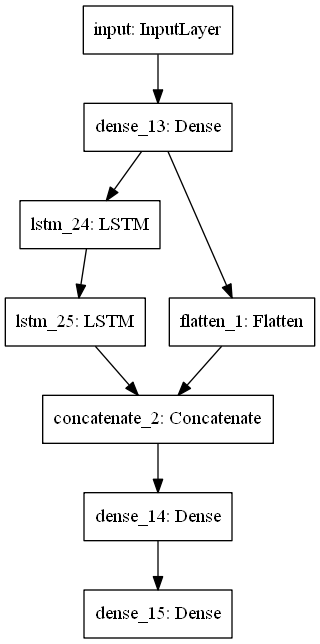

In [ ]:
keras.utils.plot_model(create_lstm8())

In [ ]:
model = create_lstm8()
manager.register_model(model, "lstm8_week", "lstm8")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_lstm9():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Dense(1000, activation="relu")(input)

    x = keras.layers.LSTM(64, return_sequences=True)(x)
    x = keras.layers.LSTM(48)(x)

    x = keras.layers.Dense(1000, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm9()
manager.register_model(model, "lstm9_week", "lstm9")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

### Regularização

Até agora, tivemos bons resultados, reduzindo principalmente as métricas de treino. Porém, ainda tínhamos um overfitting muito alto. Tentamos acrescentar regularização L2 e dropout nos modelos treinados anteriormente.

#### Regularização - LSTM9

In [ ]:
def create_lstm9_reg():
    input = keras.Input(shape=(n_features,1), name="input")
    
    #FULL
    x = keras.layers.Dense(1000, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0005))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    #LSTM
    x = keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(48, kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    #FULL
    x = keras.layers.Dense(1000, activation="relu", kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    #OUT
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm9_reg()
manager.register_model(model, "lstm9_reg_week", "lstm9_reg")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_lstm9_reg2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    #FULL
    x = keras.layers.Dense(1000, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    #LSTM
    x = keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(48, kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    #FULL
    x = keras.layers.Dense(1000, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    #OUT
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm9_reg2()
manager.register_model(model, "lstm9_reg2_week", "lstm9_reg2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

#### Regularização - Larger

In [ ]:
def create_larger_reg():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.0005))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.0005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger_reg()
manager.register_model(model, "larger_reg_week", "larger_reg")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_larger_reg2():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.005))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger_reg2()
manager.register_model(model, "larger_reg2_week", "larger_reg2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_larger_reg3():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.05))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.05))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger_reg3()
manager.register_model(model, "larger_reg3_week", "larger_reg3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_larger_reg4():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.1))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.1))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger_reg4()
manager.register_model(model, "larger_reg4_week", "larger_reg4")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
model = create_larger_reg4()
manager.register_model(model, "larger_reg4_week_200", "larger_reg4")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_larger_reg5():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.5))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(1000, activation="relu",  kernel_regularizer=keras.regularizers.l2(0.5))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_larger_reg5()
manager.register_model(model, "larger_reg5_week_200", "larger_reg5")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200, batch_size=int(BATCH_SIZE/7))

#### Regularização - LSTM7

In [ ]:
def create_lstm7_reg():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Dense(500, activation="relu", kernel_regularizer=keras.regularizers.l2(0.05))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.05))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(48, kernel_regularizer=keras.regularizers.l2(0.05))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(500, activation="relu", kernel_regularizer=keras.regularizers.l2(0.05))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm7_reg()
manager.register_model(model, "lstm7_reg_week", "lstm7_reg")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

In [ ]:
def create_lstm7_reg2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Dense(500, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.LSTM(48, kernel_regularizer=keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(500, activation="relu", kernel_regularizer=keras.regularizers.l2(0.005))(x)
    x = tf.keras.layers.Dropout(0.7)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model


In [ ]:
model = create_lstm7_reg2()
manager.register_model(model, "lstm7_reg2_week", "lstm7_reg2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

## Algoritmo genético

Já tivemos vários modelos promissores, porém estávamos até agora realizando mudanças de forma errática nos modelos. Tentamos então automatizar o processo.

Como a arquitetura com treino mais rápido e com melhor métricas até então foi utilizar duas camadas densas, decidimos utilizar essa arquitetura para otimizar os hiperparâmetros.

### AG

Iniciamos por importar de uma outra disciplina o primeiro AG simples que tínhamos criado. Ele suporta mudança dinâmica na taxa de mutação, porém os testes foram executados em poucas gerações, o que inviabiliza utilizar esse recurso.

In [ ]:
import numba

# Criamos funções para crossover utilizando média e one point.

@numba.njit
def mean(individual1, individual2):
    return (individual1+individual2)/2.0
    
@numba.njit
def one_point(individual1, individual2):
    index = np.random.randint(individual1.shape[0])

    new_individual = np.empty_like(individual1)
    new_individual[:index] = individual1[:index]
    new_individual[index:] = individual2[index:]

    return new_individual

# Mutação

@numba.njit
def mutation(individual, chromosome_size, mutation_rate, mutation_range):
    #Alterar para poder mutacionar apenas um gene
    if np.random.rand() < mutation_rate:
        individual += (2.0*(np.random.rand(chromosome_size)-0.5))*mutation_range
    
    return individual


# Classe principal para o AG
class AG:

        
    def __init__(self, population_size, mutation_rate, mutation_range, 
                cross_over = mean, dtype=np.float32, mutation_patience=5, exploration_patience=2, refinement_patience=2, dynamic_rate=True, dynamic_range=True):
        '''
            Parameters:
                mutation_patience: gerações que espera antes de determinar que está parado
                refinement_patience: ciclos de refinamento (diminuir taxa/range) que irá esperar antes de iniciar uma exploração para outro mínimo 
        '''
        
        
        #Colocar opção default que mutation_rate=1
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.mutation_range = mutation_range
        self.mutation_patience = mutation_patience
        self.refinement_patience = refinement_patience
        self.exploration_patience = exploration_patience
        self.dtype = dtype
        self.cross_over = cross_over
        self.dynamic_rate = dynamic_rate
        self.dynamic_range = dynamic_range
        
        self.mutation = mutation

        self.initial_mutation_rate =  mutation_rate
        self.initial_mutation_range = mutation_range
    
    # Seleção por torneio
    def selection(self): #tournament
        index1 = np.random.randint(self.population_size)
        index2 = np.random.randint(self.population_size)

        if self.fitness_scores[index1] > self.fitness_scores[index2]:
            return self.population[index1]
        return self.population[index2]

    # Cria uma nova população
    def new_population(self):
        new_population = np.zeros_like(self.population)
        
        best_fitness = np.argmax(self.fitness_scores)
        best_individual = self.population[best_fitness]

        self.individual_best_hist[self.current_generation] = best_individual
        self.fitness_best_hist[self.current_generation] = self.fitness_scores[best_fitness]
        self.fitness_mean_hist[self.current_generation] = np.mean(self.fitness_scores)
        self.fitness_std_hist[self.current_generation] = np.std(self.fitness_scores)


        new_population[0] = best_individual

        for i in range(1, self.population_size):
            father1 = self.selection()
            father2 = self.selection()

            new_individual = self.cross_over(father1, father2)
            new_individual = self.mutation(new_individual, self.chromosome_size, self.mutation_rate, self.mutation_range)

            new_population[i] = new_individual
        
        return new_population
        
    # Realiza a otimização
    def optimize(self, fitness_function, chromosome_size, max_cromossome_value, min_cromossome_value, n_generation):
        self.chromosome_size = chromosome_size

        self.stopped_count = 0
        self.refinement_count = 0
        self.exploration_count = 0

        self.population = np.random.rand(self.population_size, self.chromosome_size).astype(self.dtype)
        self.population *= max_cromossome_value-min_cromossome_value
        self.population += min_cromossome_value

        self.fitness_scores = np.zeros(self.population_size)

        self.individual_best_hist = np.zeros((n_generation, chromosome_size))
        self.fitness_best_hist = np.zeros(n_generation)
        self.fitness_mean_hist = np.zeros(n_generation)
        self.fitness_std_hist = np.zeros(n_generation)
        self.mutation_range_hist = np.zeros(n_generation)
        self.mutation_rate_hist = np.zeros(n_generation)
        self.generation_type = np.zeros(n_generation+1)

        self.current_generation = 0

        for i in range(n_generation):
            print("Iniciando geração", i)
            for j in range(self.population_size):
                self.fitness_scores[j] = fitness_function(self.population[j])

            self.population = self.new_population()

            self.mutation_range_hist[self.current_generation] = self.mutation_range
            self.mutation_rate_hist[self.current_generation] = self.mutation_rate

            if i > 0:
                if(abs(self.fitness_best_hist[i] - self.fitness_best_hist[i-1]) < 1E-4):
                    self.stopped_count += 1
                else:
                    self.stopped_count = 0
            
            self.current_generation += 1

            if self.stopped_count > self.mutation_patience:
                # Para -> Refina -> Para -> Explora -> Reset
                if (self.exploration_count > self.exploration_patience and 
                    self.refinement_count > self.refinement_patience):
                    #Reset
                        self.mutation_rate = self.initial_mutation_rate
                        self.mutation_range = self.initial_mutation_range

                        self.refinement_count = 0
                        self.exploration_count = 0
                        
                elif self.refinement_count > self.refinement_patience:
                    if self.exploration_count == 0:
                        # 1ª iteração de exploração
                        self.mutation_rate = self.initial_mutation_rate
                        self.mutation_range = self.initial_mutation_range
                    
                    #Exploração 
                    if self.dynamic_rate:
                        self.mutation_rate *= 2.0
                    if self.dynamic_range:
                        self.mutation_range *= 2.0
    
                    self.exploration_count += 1
                    self.generation_type[self.current_generation] = 1
                
                else:
                    #Refinamento
                    if self.dynamic_rate:
                        self.mutation_rate /= 2.0
                    if self.dynamic_range:
                        self.mutation_range /= 2.0
                    
                    self.refinement_count += 1

                    self.generation_type[self.current_generation] = -1

                self.stopped_count = 0
            

            
    # Plota o histórico de fitness
    def plot_fitness(self, max_value = None, min_value = None, min_generation=0, log=False):
        plt.plot(np.arange(self.current_generation)[min_generation:], self.fitness_best_hist[min_generation:])
        plt.plot(np.arange(self.current_generation)[min_generation:], self.fitness_mean_hist[min_generation:])
        
        plt.legend(["Best individual", "Mean"])
        plt.xlabel("Generation")
        plt.ylabel("Fitness")

        if max_value is None:
            max_value = self.fitness_best_hist[-1] + (self.fitness_best_hist[-1]/2.0)

        plt.ylim(bottom = min_value, top=max_value)

        if log:
            plt.yscale("log")
        
        plt.show()

    # Plota os indivíduos    
    def plot_individual(self):
        plt.title("Best individuals")

        for i in range(self.chromosome_size):
            plt.plot(np.arange(self.current_generation), self.individual_best_hist[: , i], label="x"+str(i))

        plt.legend()
        plt.xlabel("Generation")
        plt.ylabel("Gene")

        plt.show()
    
    # Plota os genes
    def plot_gene(self):
        fig, ax = plt.subplots(self.chromosome_size, 2, figsize=(10,10))

        for i in range(self.chromosome_size):
            ax[i][0].set_title("x"+str(i))
            ax[i][0].plot(np.arange(self.current_generation), self.individual_best_hist[: , i])
            ax[i][0].legend(["x"+str(i)])
            #ax[i][0].set_xlabel("Generation")

            ax[i][1].set_title("x"+str(i)+" - last generations")
            ax[i][1].plot(np.arange(self.current_generation)[50:], self.individual_best_hist[self.current_generation//2: , i])
            ax[i][1].legend(["x"+str(i)])

        plt.show()

    #As próximas funções de plot são apenas úteis para os verificar a taxa de mutação dinâmica
    def plot_generation_type(self):
        plt.title("Generation Type")
        plt.plot(self.generation_type)
        plt.xlabel("Geração")
        plt.ylabel("Tipo")
        plt.show()

    def plot_mutation_range(self):
        plt.title("Mutation range")
        plt.xlabel("Generation")
        plt.ylabel("Mutation Range")

        plt.plot(np.arange(self.current_generation), self.mutation_range_hist)

        plt.yscale("log")

        plt.show()
    
    def plot_mutation_rate(self):
        plt.title("Mutation rate")
        plt.xlabel("Generation")
        plt.ylabel("Mutation Rate")

        plt.plot(np.arange(self.current_generation), self.mutation_rate_hist)

        plt.yscale("log")

        plt.show()


Recriamos as funções de plot, dessa vez sem mostrar o gráfico, para conseguir realizar logging

In [ ]:
def plot_fitness(self, max_value = None, min_value = None, min_generation=0, log=False):
    plt.plot(np.arange(self.current_generation)[min_generation:], self.fitness_best_hist[min_generation:])
    plt.plot(np.arange(self.current_generation)[min_generation:], self.fitness_mean_hist[min_generation:])
    
    plt.legend(["Best individual", "Mean"])
    plt.xlabel("Generation")
    plt.ylabel("Fitness")

    if max_value is None:
        max_value = self.fitness_best_hist[-1] + (self.fitness_best_hist[-1]/2.0)

    plt.ylim(bottom = min_value, top=max_value)

    if log:
        plt.yscale("log")

def plot_individual(self):
    plt.title("Best individuals")

    for i in range(self.chromosome_size):
        plt.plot(np.arange(self.current_generation), self.individual_best_hist[: , i], label="x"+str(i))

    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel("Gene")

        

In [ ]:
# Loga os dados do AG no wandb
def log_ag(name, ag, chromosome_size, max_cromossome_value, min_cromossome_value, n_generation):

    config = {}
    config["population_size"] = ag.population_size
    config["mutation_rate"] = ag.mutation_rate
    config["mutation_range"] = ag.mutation_range
    config["mutation_patience"] = ag.mutation_patience
    config["refinement_patience"] = ag.refinement_patience
    config["exploration_patience"] = ag.exploration_patience
    config["dynamic_rate"] = ag.dynamic_rate
    config["chromosome_size"] = chromosome_size
    config["max_cromossome_value"] = max_cromossome_value
    config["min_cromossome_value"] = min_cromossome_value
    config["n_generation"] = n_generation
    config["cross_over"] = ag.cross_over.__name__

    run = wandb.init(project="BReATH_AG", entity="breath",
                        config = config)

    run.name = name

    for i in range(ag.fitness_best_hist.shape[0]):
        log_dict = {"fitness_best": ag.fitness_best_hist[i],
                    "fitness_mean": ag.fitness_mean_hist[i],
                    "fitness_std": ag.fitness_std_hist[i],
                    "mutation_range": ag.mutation_range_hist[i],
                    "mutation_rate": ag.mutation_rate_hist[i],
                    }

        for j in range(chromosome_size):
            log_dict["individual_best_"+str(j)] =  ag.individual_best_hist[i][j]

        
        wandb.log(log_dict)

    #plot_fitness(ag)
    #wandb.log({"fitness_plot":plt})
    #plt.show()

    #plot_individual(ag)
    #wandb.log({"individual_plot":plt})
    #plt.show()

    wandb.log({"fitness_best": ag.fitness_best_hist})

    wandb.finish()

Nosso primeiro teste. Tentamos otimizar apenas a quantidade de neurônios do modelo. A função para calcular o fitness utilizada foi treinar o modelo por 60 ou 100 gerações (dependendo do experimento), e calcular a média o MSE de validação das últimas gerações, para evitar ruído.

In [ ]:
fitness_hist = {}

def optimize_larger(individual:np.ndarray):
    ind = individual.astype(int)
    name = str(ind[0])+"_"+str(ind[1])
    arch_name = "larger_ag_"+name
    model_name = arch_name+"_week"

    if name in fitness_hist:
        return fitness_hist[name]


    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(ind[0], activation="relu",  kernel_regularizer=keras.regularizers.l2(0.05))(input)
    x = tf.keras.layers.Dropout(0.7)(x)

    x = keras.layers.Dense(ind[1], activation="relu",  kernel_regularizer=keras.regularizers.l2(0.05))(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    manager.register_model(model, model_name,  arch_name)
    manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=60, batch_size=int(BATCH_SIZE/7))

    fitness = np.mean(manager._hist[model_name].history["val_mean_squared_error"][-10:])

    fitness_hist[name] = fitnessa

    return fitness


In [ ]:
ag = AG(10, 1, 10)
ag.optimize(optimize_larger, 2, 1500, 100, 6)

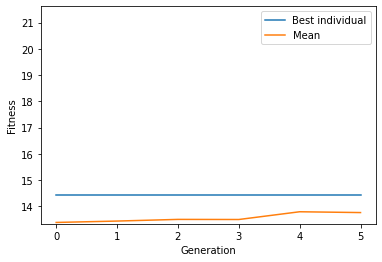

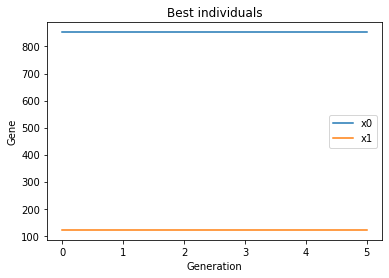

In [ ]:
ag.plot_fitness()
ag.plot_individual()

In [ ]:
log_ag("ag_larger_architecture",  ag, 2, 1500, 100, 6)

Ele demorou 29 min e 46,2 s para otimizar. Curiosamente, todos os modelos pareceram extremamente iguais. Acreditamos que isso se deve a alta taxa de dropout. Tentamos então otimizar apenas a regularização L2 e o droput.

In [ ]:
fitness_hist = {}

def optimize_larger_reg(individual:np.ndarray):
    individual = np.round(individual, 5)
    name = str(individual[0])+"_"+str(individual[1])+"_"+str(individual[2])+"_"+str(individual[3])
    arch_name = "larger_ag_reg_"+name
    model_name = arch_name+"_week"

    if name in fitness_hist:
        return fitness_hist[name]


    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(853, activation="relu",  kernel_regularizer=keras.regularizers.l2(individual[0]))(input)
    x = tf.keras.layers.Dropout(individual[2])(x)

    x = keras.layers.Dense(121, activation="relu",  kernel_regularizer=keras.regularizers.l2(individual[1]))(x)
    x = tf.keras.layers.Dropout(individual[3])(x)
    
    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    manager.register_model(model, model_name,  arch_name)
    manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, batch_size=int(BATCH_SIZE/7))

    fitness = np.mean(manager._hist[model_name].history["val_mean_squared_error"][-10:])

    fitness_hist[name] = fitness

    return fitness


In [ ]:
ag = AG(10, 1, 0.01, cross_over=one_point, dtype=np.float64)
ag.optimize(optimize_larger_reg, 4, 1, 0, 6)

In [ ]:
log_ag("ag_larger_reg",  ag, 4, 1, 0, 6)

Essa nova execução demorou 32 min e 5,6s. Tivemos mudanças mais significativas nas métricas.

Percebemos então que, até o momento, estávamos utilizando como valor para o fitness a média da loss de validação. Porém, o AG está implementado de forma a maximizar o fitness, o que implica em maximizar a loss. Todos os testes até então tentaram des-otimizar a arquitetura.

Alteramos o fitness para ser o recíproco da média da loss.

In [ ]:
fitness_hist = {}

def optimize_larger2(individual:np.ndarray):
    ind = individual.astype(int)
    name = str(ind[0])+"_"+str(ind[1])
    arch_name = "larger_ag_"+name
    model_name = arch_name+"_week"

    if name in fitness_hist:
        return fitness_hist[name]


    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(ind[0], activation="relu")(input)
    x = keras.layers.Dense(ind[1], activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    manager.register_model(model, model_name,  arch_name)
    manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=60, batch_size=int(BATCH_SIZE/7))

    fitness = np.mean(manager._hist[model_name].history["val_mean_squared_error"][-10:])
    fitness = 1.0/fitness

    fitness_hist[name] = fitness

    return fitness


In [ ]:
ag = AG(10, 1, 10, cross_over=one_point)
ag.optimize(optimize_larger2, 2, 1500, 100, 6)
log_ag("ag_larger_architecture_minimize",  ag, 2, 1500, 100, 6)

Como tivemos "melhorias" ao alterar a regularização, tentamos então otimizar tanto ela quanto a arquitetura. Também executamos esse experimento com gerações maiores (20 indivíduos, o dobro), e por mais gerações (12, o dobro).

In [ ]:
fitness_hist = {}

def optimize_both(individual:np.ndarray):
    individual = np.round(individual, decimals=5)
    individual = np.clip(individual, 0.0, 1.0)

    units = individual[:2]
    reg = individual[2:]

    reg = np.clip(reg, 0.0, 0.99999)

    units *= 1900
    units += 100
    units = units.astype(int)

    name = ""
    for i in range(2):
        name += str(units[i])+"_"
    for i in range(4):
        name += str(reg[i])+"_"
    
    arch_name = "larger_ag_both_"+name
    model_name = arch_name+"week"

    if name in fitness_hist:
        return fitness_hist[name]


    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(units[0], activation="relu", kernel_regularizer=keras.regularizers.l2(reg[0]))(input)
    x = tf.keras.layers.Dropout(reg[2])(x)
    
    x = keras.layers.Dense(units[1], activation="relu", kernel_regularizer=keras.regularizers.l2(reg[1]))(x)
    x = tf.keras.layers.Dropout(reg[3])(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    manager.register_model(model, model_name,  arch_name)
    manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=60, batch_size=int(BATCH_SIZE/7), group="ag_optimize_both2", verbose=0)

    fitness = np.mean(manager._hist[model_name].history["val_mean_squared_error"][-10:])
    fitness = 1.0/fitness

    fitness_hist[name] = fitness

    return fitness


In [ ]:
ag = AG(20, 1, 0.1, cross_over=one_point, dtype=np.float64)
ag.optimize(optimize_both, 6, 1, 0, 12)
log_ag("ag_larger_both2",  ag, 6, 1, 0, 12)

In [ ]:
log_ag("ag_larger_both2",  ag, 6, 1, 0, 12)

Como tivemos que parar a otimização no meio do processo, por risco de danificar o computador durante uma tempestade, serializamos e salvamos o AG.

In [ ]:
file = open("ag_backup", 'wb')
pickle.dump(ag, file)
file.close()

In [ ]:
file = open("ag_backup", 'rb')
ag = pickle.load(file)
file.close()

Criamos uma função para continuar o processo de evolução

In [ ]:
def continue_optimize(self, fitness_function, n_generation):
    stopped_generation = self.current_generation

    for i in range(stopped_generation, n_generation):
        print("Iniciando geração", i)
        for j in range(self.population_size):
            self.fitness_scores[j] = fitness_function(self.population[j])

        self.population = self.new_population()

        self.mutation_range_hist[self.current_generation] = self.mutation_range
        self.mutation_rate_hist[self.current_generation] = self.mutation_rate

        if i > 0:
            if(abs(self.fitness_best_hist[i] - self.fitness_best_hist[i-1]) < 1E-4):
                self.stopped_count += 1
            else:
                self.stopped_count = 0
        
        self.current_generation += 1

        if self.stopped_count > self.mutation_patience:
            # Para -> Refina -> Para -> Explora -> Reset
            if (self.exploration_count > self.exploration_patience and 
                self.refinement_count > self.refinement_patience):
                #Reset
                    self.mutation_rate = self.initial_mutation_rate
                    self.mutation_range = self.initial_mutation_range

                    self.refinement_count = 0
                    self.exploration_count = 0
                    
            elif self.refinement_count > self.refinement_patience:
                if self.exploration_count == 0:
                    # 1ª iteração de exploração
                    self.mutation_rate = self.initial_mutation_rate
                    self.mutation_range = self.initial_mutation_range
                
                #Exploração 
                if self.dynamic_rate:
                    self.mutation_rate *= 2.0
                if self.dynamic_range:
                    self.mutation_range *= 2.0

                self.exploration_count += 1
                self.generation_type[self.current_generation] = 1
            
            else:
                #Refinamento
                if self.dynamic_rate:
                    self.mutation_rate /= 2.0
                if self.dynamic_range:
                    self.mutation_range /= 2.0
                
                self.refinement_count += 1

                self.generation_type[self.current_generation] = -1

            self.stopped_count = 0

In [ ]:
import types

ag.continue_optimize = types.MethodType(continue_optimize, ag)

E terminamos a otimização

In [ ]:
ag.continue_optimize(optimize_both, 12)

In [ ]:
log_ag("ag_larger_both3",  ag, 6, 1, 0, 12)

### Conclusão

O AG conseguiu gerar resultados interessantes, porém não chegou ao melhor resultado que tínhamos conseguido alterando manualmente os parâmetros. Talvez utilizar outros parâmetros para o AG, ou treinar por mais gerações, poderia resolver o problema.

Como não tínhamos tempo para isso, e não é o objetivo desse trabalho gerar o modelo mais otimizado de todos, decidimos parar a hiperotimização com os resultados que já tivemos.

## Treino dos melhores

Por fim, treinamos os melhores algoritmos por mais epochs, com parada antecipada. Os modelos não treinaram muito mais que já haviam sido treinados anteriormente.

### ag_best

Melhor modelo selecionado pelo AG.

In [ ]:
ag.individual_best_hist[-1]

array([0.08171292, 0.83180579, 0.33090176, 0.00938583, 0.51035982,
       0.63681597])

In [ ]:
def print_best(individual:np.ndarray):
    individual = np.round(individual, decimals=5)
    individual = np.clip(individual, 0.0, 1.0)

    units = individual[:2]
    reg = individual[2:]

    reg = np.clip(reg, 0.0, 0.99999)

    units *= 1900
    units += 100
    units = units.astype(int)

    print("Unidades:",units[0], units[1])
    print("Regularização L2:", reg[0], reg[1])
    print("Dropout:", reg[2], reg[3])

print_best(ag.individual_best_hist[-1]) 

Unidades: 255 1680
Regularização L2: 0.3309 0.00939
Dropout: 0.51036 0.63682


In [ ]:
def create_ag_best():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(255, activation="relu", kernel_regularizer=keras.regularizers.l2(0.3309))(input)
    x = tf.keras.layers.Dropout(0.51036)(x)
    
    x = keras.layers.Dense(1680, activation="relu", kernel_regularizer=keras.regularizers.l2(0.00939))(x)
    x = tf.keras.layers.Dropout(0.63682)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
model = create_ag_best()
manager.register_model(model, "ag_best", "ag_best")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=1000, batch_size=int(BATCH_SIZE/7), patience=50)
manager.save("ag_best")

Epoch 1/1000
22/22 [==============================] - 3s 33ms/step - loss: 13.8653 - mean_absolute_error: 0.3459 - mean_squared_error: 5.4861 - val_loss: 21.1583 - val_mean_absolute_error: 0.4982 - val_mean_squared_error: 15.0168
Epoch 2/1000
22/22 [==============================] - 0s 21ms/step - loss: 9.7514 - mean_absolute_error: 0.2927 - mean_squared_error: 4.9348 - val_loss: 20.0301 - val_mean_absolute_error: 0.5187 - val_mean_squared_error: 16.4139
Epoch 3/1000
22/22 [==============================] - 0s 21ms/step - loss: 7.8064 - mean_absolute_error: 0.2745 - mean_squared_error: 4.8766 - val_loss: 16.4926 - val_mean_absolute_error: 0.4623 - val_mean_squared_error: 14.2075
Epoch 4/1000
22/22 [==============================] - 0s 21ms/step - loss: 6.7065 - mean_absolute_error: 0.2732 - mean_squared_error: 4.8158 - val_loss: 17.8614 - val_mean_absolute_error: 0.5267 - val_mean_squared_error: 16.3386
Epoch 5/1000
22/22 [==============================] - 0s 21ms/step - loss: 6.0625 -

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▅▅▅▅▄▄▄▄▄▄▄▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▃▄▄▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
val_mean_absolute_error,█▆█▇▆▆▇██▆▇▆▅▄▅▅▃▂▂▂▂▂▁▄▂▂▁▃▂▃▂▃▃▃▃▄▄▄▄▄
val_mean_squared_error,█▆█▇▆▆▆▇▇▆▆▅▅▃▄▃▂▂▂▂▁▁▂▃▂▃▂▃▃▃▃▃▄▄▄▄▄▅▄▅
best_epoch,58
best_val_mean_squared_error,10.35238
epoch,108
loss,4.15608


### larger_reg3

Melhor de todos  (possuia a melhor MSE de validação na última epoch).

In [ ]:
model = create_larger_reg3()
manager.register_model(model, "larger_reg3_longer", "larger_reg3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=1000, batch_size=int(BATCH_SIZE/7), patience=50)
manager.save("larger_reg3_longer")

###  lstm3_longer

Melhor LSTM (possuia a melhor MSE de validação na última epoch).

In [ ]:
model = create_lstm3()
manager.register_model(model, "lstm3_longer", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=1000, batch_size=int(BATCH_SIZE/7), patience=50)
manager.save("lstm3_longer")